In [ ]:
using LinearAlgebra
using CUDAnative
using CuArrays
using BenchmarkTools
using Images
using CUDAdrv

## Terminology

1. A thread is an "independent" execution of a kernel.
2. Threads are grouped into 3-dimensional "blocks".
3. Blocks are grouped into 3-dimensional "grids".
4. Blocks are independently scheduled and executed.

In [9]:
function hello_world()
    @cuprintf("Thread index: (%ld, %ld, %ld)\n", threadIdx().x, threadIdx().y, threadIdx().z)
    @cuprintf("Block index: (%ld, %ld, %ld)\n", blockIdx().x, blockIdx().y, blockIdx().z)
    return
end

@cuda blocks=(2, 3, 2) threads=(1, 2, 3) hello_world()

Thread index: (1, 1, 1)
Thread index: (1, 2, 1)
Thread index: (1, 1, 2)
Thread index: (1, 2, 2)
Thread index: (1, 1, 3)
Thread index: (1, 2, 3)
Thread index: (1, 1, 1)
Thread index: (1, 2, 1)
Thread index: (1, 1, 2)
Thread index: (1, 2, 2)
Thread index: (1, 1, 3)
Thread index: (1, 2, 3)
Thread index: (1, 1, 1)
Thread index: (1, 2, 1)
Thread index: (1, 1, 2)
Thread index: (1, 2, 2)
Thread index: (1, 1, 3)
Thread index: (1, 2, 3)
Thread index: (1, 1, 1)
Thread index: (1, 2, 1)
Thread index: (1, 1, 2)
Thread index: (1, 2, 2)
Thread index: (1, 1, 3)
Thread index: (1, 2, 3)
Thread index: (1, 1, 1)
Thread index: (1, 2, 1)
Thread index: (1, 1, 2)
Thread index: (1, 2, 2)
Thread index: (1, 1, 3)
Thread index: (1, 2, 3)
Thread index: (1, 1, 1)
Thread index: (1, 2, 1)
Thread index: (1, 1, 2)
Thread index: (1, 2, 2)
Thread index: (1, 1, 3)
Thread index: (1, 2, 3)
Thread index: (1, 1, 1)
Thread index: (1, 2, 1)
Thread index: (1, 1, 2)
Thread index: (1, 2, 2)
Thread index: (1, 1, 3)
Thread index: (1

## Obligatory vector add example

In [36]:
function vadd_cpu(a, b, c)
    for i in eachindex(a)
        c[i] = a[i] + b[i]
    end
end

function vadd(a, b, c)
    i = blockIdx().x
    c[i] = a[i] + b[i]
    return
end

vadd (generic function with 1 method)

In [3]:
N = 100_000_000
a = collect(1:N); b = collect(1:N); c = collect(1:N);
dev_a = CuArray(a) ; dev_b = CuArray(b) ; dev_c = similar(dev_a);

In [4]:
@btime vadd_cpu($a, $b, $c)

  218.193 ms (0 allocations: 0 bytes)


In [5]:
@btime @cuda blocks=N vadd(dev_a, dev_b, dev_c)

  12.609 μs (64 allocations: 2.08 KiB)


## Cooler Julia Set example

In [37]:
function julia(x, y)
    z = complex(x, y)
    c = complex(-0.8, 0.156)
    
    for i in 1:100
        z = z^2 + c
        if norm(z) > 100
            return 0
        end
    end
    return 1
end

function gpu_julia(buffer)
    x = blockIdx().x
    y = blockIdx().y
    _, w, h = size(buffer)
    
    result = julia(3(x - w/2) / w, 3(y - h/2) / h)
    
    buffer[1, x, y] = 0
    buffer[2, x, y] = 0
    buffer[3, x, y] = result
    return
end

function cpu_julia(buffer)
    _, w, h = size(buffer)
    for x in 1:size(buffer)[2], y in 1:size(buffer)[3]
        result = julia(3(x - w/2) / w, 3(y - h/2) / h)
        
        
        buffer[1, x, y] = result
        buffer[2, x, y] = 0
        buffer[3, x, y] = 0
    end
end

cpu_julia (generic function with 1 method)

In [38]:
x = zeros(3, 1000, 1000);
dx = CuArray(x);

In [8]:
@btime cpu_julia(x)

  102.140 ms (0 allocations: 0 bytes)


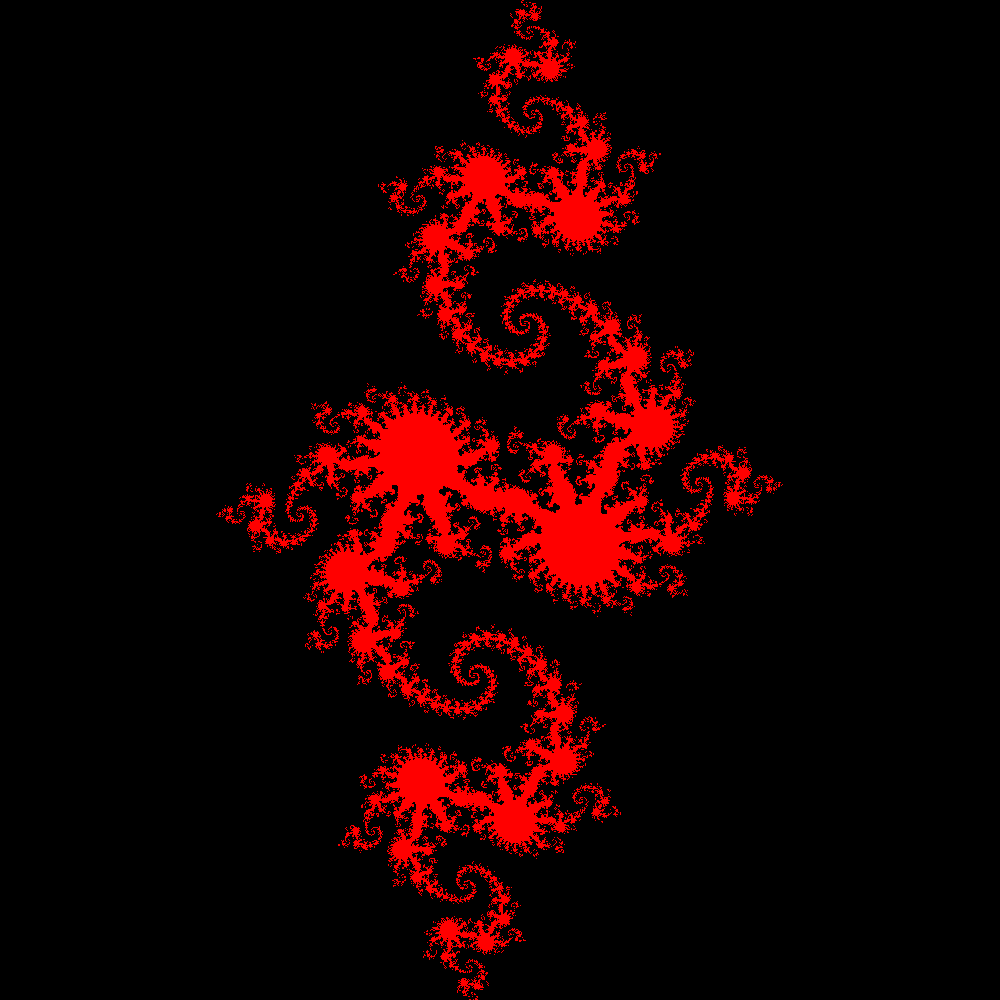

In [9]:
colorview(RGB, x)

In [10]:
@btime @cuda blocks=(1000, 1000) gpu_julia(dx)

┌ Warning: calls to Base intrinsics might be GPU incompatible
│   exception = (CUDAnative.MethodSubstitutionWarning(hypot(x::T, y::T) where T<:Number in Base.Math at math.jl:541, hypot(x::Float64, y::Float64) in CUDAnative at /home/max/.julia/packages/CUDAnative/nItlk/src/device/cuda/math.jl:291), Base.StackTraces.StackFrame[hypot at math.jl:541, gpu_julia at In[6]:15])
└ @ CUDAnative /home/max/.julia/packages/CUDAnative/nItlk/src/compiler/irgen.jl:107


  25.302 μs (26 allocations: 864 bytes)


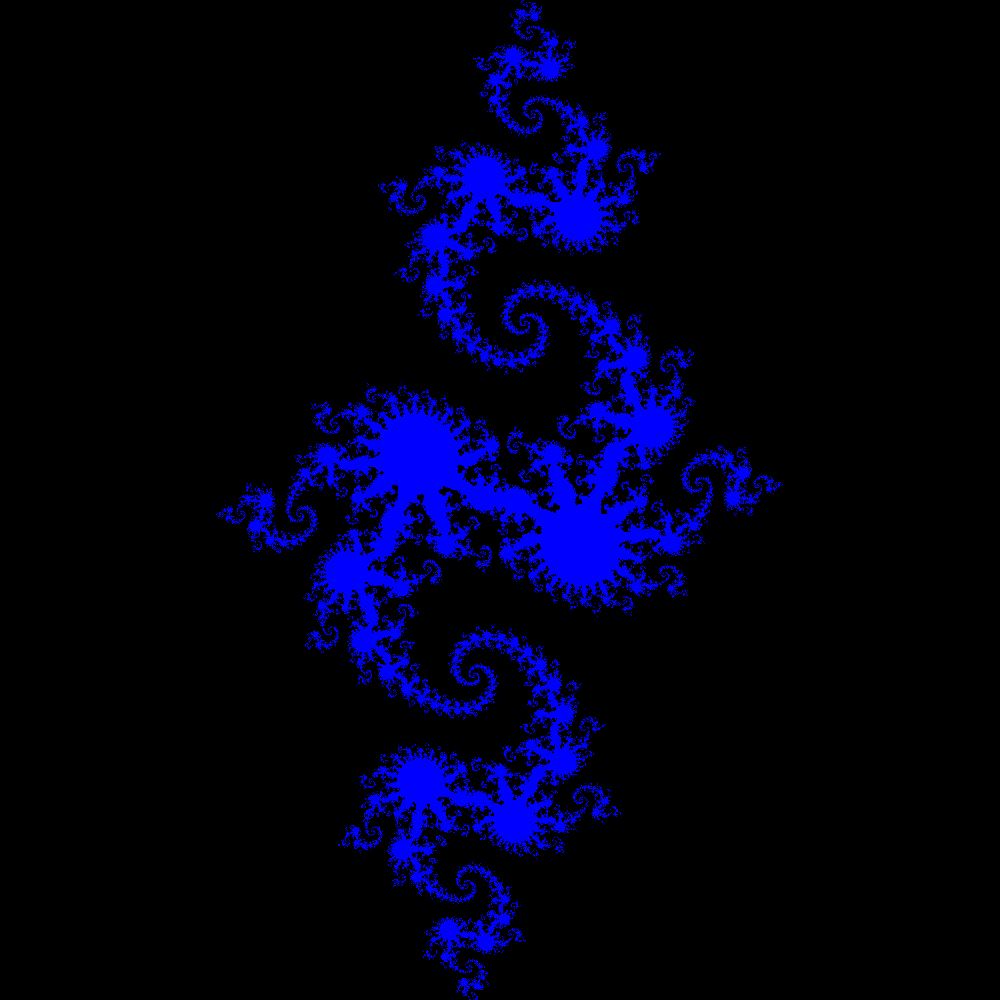

In [11]:
colorview(RGB, Array(dx))

## Warps


In [54]:
function warpsz()
    @cuprintf("Warpsize: %ld", CUDAnative.warpsize())
    return
end

@cuda warpsz()
synchronize()

Warpsize: 32

In [55]:
CUDAdrv.warpsize(CUDAdrv.device())

32

## Synchronization

In [45]:
buf = CuArrays.zeros(100)
function needs_sync(r)
    x = threadIdx().x
    r[x] = x
    sync_threads()
    r[101 - x] += r[x]
    return
end

@cuda threads=100 foo(buf)
synchronize()

all(buf .== 101.0)

true

In [35]:
function gpu_test()
    cache = CUDAnative.@cuStaticSharedMem(Float64, 100)
    idx = threadIdx().x
    cache[idx] = idx
    i = 1
    @cuprintf("%f\n", cache[idx+i])
    return
end

gpu_test (generic function with 1 method)

In [36]:
@cuda threads=10 gpu_test()

2.000000
3.000000
4.000000
5.000000
6.000000
7.000000
8.000000
9.000000
10.000000
0.000000


In [41]:
function gpu_dot(a, b)
    cache = CUDAnative.@cuStaticSharedMem(Float64, 100)
    step = blockDim().x * gridDim().x
    tid = threadIdx().x
    temp = 0
    for i in tid:step:length(a)
        temp += a[i] * b[i]
    end
    
    cache[tid] = temp
    
    sync_threads()
    
    i = length(a) / 2
    while i != 1
        if tid < i
            second = cache[tid + i]
            cache[tid] = cache[tid]
        end
        
        sync_threads()
        
        i /= 2
    end
    
    return
end

gpu_dot (generic function with 1 method)

In [42]:
da = CuArray([1, 2, 3, 4])
db = CuArray([1, 2, 3, 4])
c = nothing

@cuda blocks=4 threads=1 gpu_dot(da, db)

CUDAnative.InvalidIRError: InvalidIRError: compiling gpu_dot(CuDeviceArray{Int64,1,CUDAnative.AS.Global}, CuDeviceArray{Int64,1,CUDAnative.AS.Global}) resulted in invalid LLVM IR
Reason: unsupported call through a literal pointer (call to jl_alloc_string)
Stacktrace:
 [1] _string_n at strings/string.jl:60
 [2] StringVector at iobuffer.jl:31
 [3] #IOBuffer#302 at iobuffer.jl:114
 [4] Type at none:0
 [5] print_to_string at strings/io.jl:120
 [6] string at strings/io.jl:155
 [7] to_index at indices.jl:266
 [8] to_index at indices.jl:247
 [9] to_indices at indices.jl:294
 [10] to_indices at indices.jl:291
 [11] getindex at abstractarray.jl:905
 [12] gpu_dot at In[41]:17
Reason: unsupported call through a literal pointer (call to jl_string_to_array)
Stacktrace:
 [1] unsafe_wrap at strings/string.jl:71
 [2] StringVector at iobuffer.jl:31
 [3] #IOBuffer#302 at iobuffer.jl:114
 [4] Type at none:0
 [5] print_to_string at strings/io.jl:120
 [6] string at strings/io.jl:155
 [7] to_index at indices.jl:266
 [8] to_index at indices.jl:247
 [9] to_indices at indices.jl:294
 [10] to_indices at indices.jl:291
 [11] getindex at abstractarray.jl:905
 [12] gpu_dot at In[41]:17
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] fill! at array.jl:380
 [2] #IOBuffer#302 at iobuffer.jl:121
 [3] Type at none:0
 [4] print_to_string at strings/io.jl:120
 [5] string at strings/io.jl:155
 [6] to_index at indices.jl:266
 [7] to_index at indices.jl:247
 [8] to_indices at indices.jl:294
 [9] to_indices at indices.jl:291
 [10] getindex at abstractarray.jl:905
 [11] gpu_dot at In[41]:17
Reason: unsupported dynamic function invocation (call to print)
Stacktrace:
 [1] print_to_string at strings/io.jl:117
 [2] string at strings/io.jl:155
 [3] to_index at indices.jl:266
 [4] to_index at indices.jl:247
 [5] to_indices at indices.jl:294
 [6] to_indices at indices.jl:291
 [7] getindex at abstractarray.jl:905
 [8] gpu_dot at In[41]:17
Reason: unsupported dynamic function invocation (call to print)
Stacktrace:
 [1] print_to_string at strings/io.jl:122
 [2] string at strings/io.jl:155
 [3] to_index at indices.jl:266
 [4] to_index at indices.jl:247
 [5] to_indices at indices.jl:294
 [6] to_indices at indices.jl:291
 [7] getindex at abstractarray.jl:905
 [8] gpu_dot at In[41]:17
Reason: unsupported call through a literal pointer (call to jl_array_grow_end)
Stacktrace:
 [1] _growend! at array.jl:814
 [2] resize! at array.jl:1006
 [3] print_to_string at strings/io.jl:124
 [4] string at strings/io.jl:155
 [5] to_index at indices.jl:266
 [6] to_index at indices.jl:247
 [7] to_indices at indices.jl:294
 [8] to_indices at indices.jl:291
 [9] getindex at abstractarray.jl:905
 [10] gpu_dot at In[41]:17
Reason: unsupported call through a literal pointer (call to jl_array_del_end)
Stacktrace:
 [1] _deleteend! at array.jl:823
 [2] resize! at array.jl:1011
 [3] print_to_string at strings/io.jl:124
 [4] string at strings/io.jl:155
 [5] to_index at indices.jl:266
 [6] to_index at indices.jl:247
 [7] to_indices at indices.jl:294
 [8] to_indices at indices.jl:291
 [9] getindex at abstractarray.jl:905
 [10] gpu_dot at In[41]:17
Reason: unsupported call through a literal pointer (call to jl_array_to_string)
Stacktrace:
 [1] Type at strings/string.jl:39
 [2] print_to_string at strings/io.jl:124
 [3] string at strings/io.jl:155
 [4] to_index at indices.jl:266
 [5] to_index at indices.jl:247
 [6] to_indices at indices.jl:294
 [7] to_indices at indices.jl:291
 [8] getindex at abstractarray.jl:905
 [9] gpu_dot at In[41]:17